<a href="https://colab.research.google.com/github/AmirHoseein99/Depression-Engine/blob/master/DepressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import pickle
import logging 
import sklearn
import librosa
import itertools
import numpy as np
import pandas as pd
from PIL import Image
import librosa.display
import tensorflow as tf
from tensorflow import keras
from scipy.io.wavfile import write
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
SAMPLR_RATE = 16000
! install h5py
import h5py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def read_transcript(path):
  all_transcripts = {}
  all_files = glob.glob(path + "/*.csv")
  for filename in all_files:
    id = int(filename.split("/")[-1].split("_")[0])
    transcript = pd.read_csv(filename, sep='\t')
    participants_lines = transcript[transcript.speaker == "Participant"][["start_time", "stop_time"]]
    all_transcripts[id] = participants_lines
  return all_transcripts

In [ ]:
def exctract_participant_lines(path):
  all_participants_audios = {}
  all_files = glob.glob(path + "/*.wav")
  for filename in all_files:
    a_participant_audio = []
    id = int(filename.split("/")[-1].split("_")[0])
    audio, _ = librosa.load(filename, sr = SAMPLR_RATE)
    transcript = test_transcripts[id]
    for i in range(len(transcript)):
      audio_start_time = round(transcript.iloc[i].start_time * SAMPLR_RATE)
      audio_stop_time = round(transcript.iloc[i].stop_time * SAMPLR_RATE)
      a_participant_audio.append(audio[audio_start_time:audio_stop_time])
    
    a_participant_audio = np.array(a_participant_audio, dtype=object)
    all_participants_audios[id] = a_participant_audio
  return all_participants_audios

In [ ]:
not_dep_participants_mels = {}
widowns_size = 2 * SAMPLR_RATE 
step_size = 2 * SAMPLR_RATE 
def split_audios(audio_dict):

  for key in audio_dict.keys():
    mels = []
    filename = key
    print(f"{filename} : Started")
    audio = audio_dict[key]
    audios_part = slidingWindow(audio, widowns_size, step_size)
    print(f"{filename} : Splited")

    for i in range(len(audios_part)):
      mel_spectogram = librosa.feature.melspectrogram(y=audios_part[i], sr=SAMPLR_RATE,
                                      n_fft=400, hop_length=160, win_length=400, window='hamming', n_mels = 32).T
      mels.append(mel_spectogram)
    mels = np.array(mels) 

    not_dep_participants_mels[key] = mels

    print(f"{filename} : Done")
  print(f"All_Audios : Done")

In [ ]:
from scipy import stats

def slidingWindow(X,window_size=32, step=10):
    windowed_mels = []
    for i in range(0, len(X) - window_size, step):
        x = X[i:(i + window_size)]
        windowed_mels.append(x)
    return np.array(windowed_mels)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def feature_exctraction(path):
    mels = []
    all_files = glob.glob(path + "/*.wav")
    dir_id  = int(path.split("/")[-1])
    for ten_sec_file in all_files:
      id = int(ten_sec_file.split("/")[-1].split('.')[0])
      
      ten_sec_audio, _ = librosa.load(ten_sec_file, sr=SAMPLR_RATE)
      mel_spectogram = librosa.feature.melspectrogram(y=ten_sec_audio, sr=SAMPLR_RATE,
                                      n_fft=480, hop_length=160, win_length=480, window='hamming').T
      mel_spectogram = scaler.fit_transform(mel_spectogram)
      mels.append(mel_spectogram)
    mels = np.array(mels)
    print(dir_id, mels.shape)
    return mels, dir_id


In [ ]:
def get_mels (path):
    all_mel_spectograms = {}
    all_pathes = []
    for x in os.walk(path):
      all_pathes.append(x[0])
    all_pathes = all_pathes[1:]
    for ten_sec_audio_path in all_pathes:
      mels, id = feature_exctraction(ten_sec_audio_path)
      all_mel_spectograms[id] = mels
    return all_mel_spectograms

In [ ]:
from sklearn.utils import shuffle 
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
model = keras.models.Sequential([
  keras.layers.Input((401, 32)),
  keras.layers.Reshape((401, 32, 1)),
  keras.layers.Conv1D(1, (1, 3), activation="relu", padding="same"),
  keras.layers.MaxPooling2D(2),
  keras.layers.Conv1D(1, (3, 1), activation="relu", padding="same"),
  keras.layers.MaxPooling2D(2),
  keras.layers.Conv1D(1, (1, 3), activation="relu", padding="same"),
  keras.layers.MaxPooling2D(2),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
models = [model_1, model_2, model_3, model_4]
model_input = tf.keras.Input(shape= (201, 32, 1))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

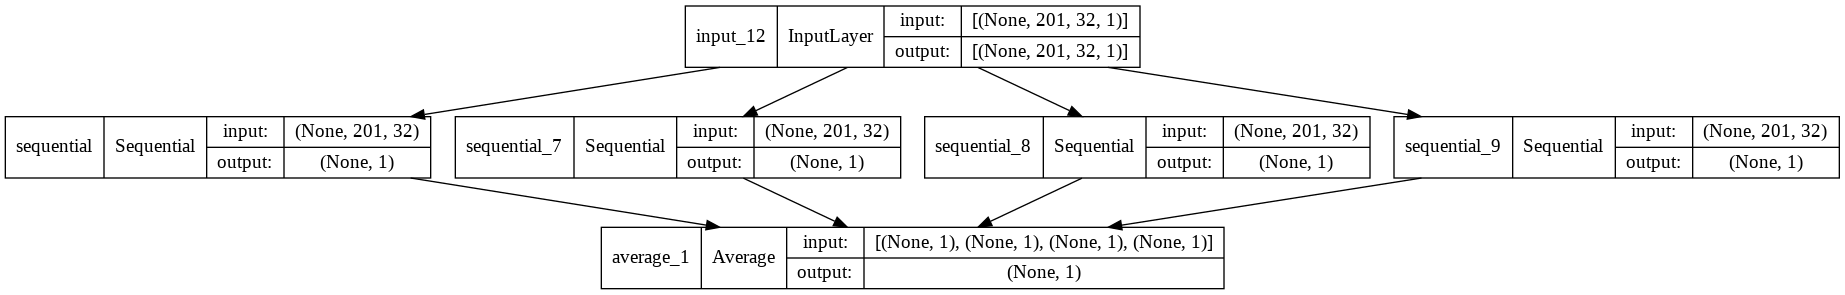

In [ ]:
plot_model(ensemble_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
ensemble_model.compile(
    optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=0.001, nesterov=True
                                     ),
    loss = 'binary_crossentropy',
    metrics = [
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(name='auc'),
           ],
)


In [ ]:
callbacks = [
      keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
      keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001)
]

In [ ]:
history = ensemble_model.fit(X_train, y_train, epochs=100, callbacks=callbacks, verbose=1,
                    validation_data = (X_valid, y_valid), batch_size=32)

In [ ]:

pd.DataFrame(history.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]